In [1]:
import os
import numpy as np
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.datasets import VOCSegmentation
import matplotlib.pyplot as plt
import cv2

In [2]:
# Load the VOC dataset
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def target_transform(mask):
    mask = mask.resize((256, 256), Image.NEAREST)
    mask = np.array(mask)
    mask = torch.from_numpy(mask).long()
    return mask

In [3]:
train_dataset = VOCSegmentation(root='./data', year='2012', image_set='train', download=True, transform=transform, target_transform=target_transform)
val_dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transform=transform, target_transform=target_transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)

100%|██████████| 1999639040/1999639040 [02:14<00:00, 14877597.41it/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [4]:
!pip install segmentation-models-pytorch


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.3 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_6

In [5]:
import segmentation_models_pytorch as smp

# Load the pretrained UNet model with ResNet-34 encoder
model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=21  # Number of classes for Pascal VOC
)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 159MB/s]


In [6]:
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [70]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device).long()
        optimizer.zero_grad()
        outputs = model(inputs)
        labels = labels.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).long()
            outputs = model(inputs)
            labels = labels.squeeze(1)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss}')

Training Epoch 1/10: 100%|██████████| 183/183 [00:32<00:00,  5.62it/s]


Epoch 1/10, Loss: 0.8802878850144766
Epoch 1/10, Validation Loss: 0.9418378953750317


Training Epoch 2/10: 100%|██████████| 183/183 [00:32<00:00,  5.68it/s]


Epoch 2/10, Loss: 0.8296318845670732
Epoch 2/10, Validation Loss: 0.880614195551191


Training Epoch 3/10: 100%|██████████| 183/183 [00:32<00:00,  5.69it/s]


Epoch 3/10, Loss: 0.822961386272816
Epoch 3/10, Validation Loss: 0.8639283481535021


Training Epoch 4/10: 100%|██████████| 183/183 [00:32<00:00,  5.70it/s]


Epoch 4/10, Loss: 0.8088378523542581
Epoch 4/10, Validation Loss: 0.9194325493587242


Training Epoch 5/10: 100%|██████████| 183/183 [00:32<00:00,  5.72it/s]


Epoch 5/10, Loss: 0.78853808498122
Epoch 5/10, Validation Loss: 0.937492712022184


Training Epoch 6/10: 100%|██████████| 183/183 [00:32<00:00,  5.68it/s]


Epoch 6/10, Loss: 0.7638500581999295
Epoch 6/10, Validation Loss: 0.8772578530914181


Training Epoch 7/10: 100%|██████████| 183/183 [00:31<00:00,  5.76it/s]


Epoch 7/10, Loss: 0.7574643393357595
Epoch 7/10, Validation Loss: 0.9432518698356964


Training Epoch 8/10: 100%|██████████| 183/183 [00:31<00:00,  5.77it/s]


Epoch 8/10, Loss: 0.720481683810552
Epoch 8/10, Validation Loss: 0.9642018729841316


Training Epoch 9/10: 100%|██████████| 183/183 [00:31<00:00,  5.75it/s]


Epoch 9/10, Loss: 0.7037810059518762
Epoch 9/10, Validation Loss: 1.004826721909282


Training Epoch 10/10: 100%|██████████| 183/183 [00:31<00:00,  5.80it/s]


Epoch 10/10, Loss: 0.670340266221208
Epoch 10/10, Validation Loss: 0.9033869807864283


In [72]:
def create_pascal_voc_label_colormap():
    colormap = np.zeros((256, 3), dtype=np.uint8)
    colormap[0] = [0, 0, 0]          # background
    colormap[1] = [128, 0, 0]        # aeroplane
    colormap[2] = [0, 128, 0]        # bicycle
    colormap[3] = [128, 128, 0]      # bird
    colormap[4] = [0, 0, 128]        # boat
    colormap[5] = [128, 0, 128]      # bottle
    colormap[6] = [0, 128, 128]      # bus
    colormap[7] = [128, 128, 128]    # car
    colormap[8] = [64, 0, 0]         # cat
    colormap[9] = [192, 0, 0]        # chair
    colormap[10] = [64, 128, 0]      # cow
    colormap[11] = [192, 128, 0]     # dining table
    colormap[12] = [64, 0, 128]      # dog
    colormap[13] = [192, 0, 128]     # horse
    colormap[14] = [64, 128, 128]    # motorbike
    colormap[15] = [192, 128, 128]   # person
    colormap[16] = [0, 64, 0]        # potted plant
    colormap[17] = [128, 64, 0]      # sheep
    colormap[18] = [0, 192, 0]       # sofa
    colormap[19] = [128, 192, 0]     # train
    colormap[20] = [0, 64, 128]      # tv/monitor
    return colormap

In [78]:
# Function to map the segmentation output to colors
def decode_segmap(image, colormap):
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    for l in range(0, 256):
        idx = image == l
        r[idx] = colormap[l, 0]
        g[idx] = colormap[l, 1]
        b[idx] = colormap[l, 2]
    rgb = np.stack([r, g, b], axis=2)
    return rgb
# Create a color map
colormap = create_pascal_voc_label_colormap()

In [105]:
sample_idx = 43 # Change this to any valid index to select a different image
original_img, test_mask = val_dataset[sample_idx]  # Get the original image and mask

# Convert the original image to a numpy array suitable for OpenCV
original_img_np = np.array(original_img.permute(1, 2, 0))  # Convert PIL Image to numpy array, ensuring proper channel order

# Remove the transform step as it's already a tensor
test_img = original_img.unsqueeze(0).to(device)  # Move to device

with torch.no_grad():
    output = model(test_img)
output_predictions = output.argmax(1).squeeze(0).cpu().numpy()

# Convert the input image to a format suitable for OpenCV
input_image_cv = cv2.cvtColor(np.array(original_img_np), cv2.COLOR_RGB2BGR)  # Use the original image for display

# Overlay the segmentation mask on the original image
def overlay_segmentation(image, mask):
    alpha = 0.6  # Transparency factor
    colormap = create_pascal_voc_label_colormap()
    color_mask = colormap[mask].astype(np.uint8)
    image = image.astype(np.uint8)
    overlay = cv2.addWeighted(image, alpha, color_mask, 1 - alpha, 0)
    return overlay

segmented_image = overlay_segmentation(input_image_cv, output_predictions)

# Decode the segmentation map
colormap = create_pascal_voc_label_colormap()
seg_map = decode_segmap(output_predictions, colormap)

# Display the segmentation result using matplotlib
plt.figure(figsize=(20, 20))


<Figure size 2000x2000 with 0 Axes>

<Figure size 2000x2000 with 0 Axes>

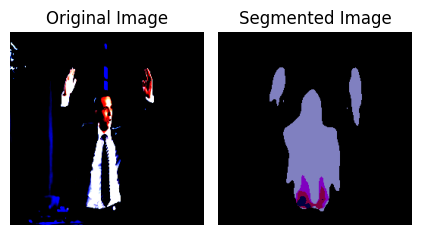

In [106]:
# Display original image
plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(input_image_cv, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')


# Display segmentation map
plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(seg_map, cv2.COLOR_BGR2RGB))
plt.title('Segmented Image')
plt.axis('off')

# Show plot
plt.tight_layout()
plt.show()